# Important
### The spatial join block runs but sometimes require a few tries before it does so successfully. I have ran the code a few times before submitting so everything does run, it's just arcpy acting up.

## Importing Libraries

In [2]:
## Importing Libraries
import arcpy
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
import pandas as pd
import geopandas as gpd ## Only using it for choropleth maps

arcpy.CheckOutExtension("Spatial")

'CheckedOut'

## Setting Working Directory 



In [4]:
base = os.getcwd() ## Since I have connected my folder to vscode, I have set base as current working directory 
arcpy.env.workspace = os.path.join(base, 'Data')
arcpy.env.overwriteOutput = True

In [5]:
os.path.join(base, 'Data')

's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data'

## Loading in the DATA


In [6]:
census_tracts = "Census_Tracts_in_2020.shp"
dc_schools = "DC_Public_Schools.shp"
Median_household_income = "ACS_2018_Median_Household_Income_Variables_Tract.shp"

## Spatial join to count the numer of schools in each tract

In [7]:
output_fc = "schools_in_tracts.shp"

arcpy.analysis.SpatialJoin(
    target_features=census_tracts, ## This is a polygon
    join_features=dc_schools, ## THis is a point
    out_feature_class=output_fc,
    join_operation="JOIN_ONE_TO_ONE",  
    join_type="Keep_ALL", ## Keep All keeps even the census tracts that have no school
    match_option="Completely contains" ## Completely contains becuase our join feature are points and target is polygon
)


<Result 's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data\\schools_in_tracts.shp'>

In [6]:
## This was the code to calculate the total student population in each tract. Have commented it out cause the field is already created and for some reason it was giving me problems when running it again

"""arcpy.analysis.Statistics(
    in_table=output_fc,
    out_table="students_summary_table.dbf",  # Replace with the desired output table name and path
    statistics_fields=[["TOTAL_STUD", "SUM"]],
    case_field="GEOID"  # Replace with the actual field name that represents the tract ID
)

# Join the summary statistics table back to the census tracts
arcpy.management.JoinField(
    in_data=census_tracts,  # Replace with the actual path to your census tracts shapefile
    in_field="GEOID",  # Replace with the actual field name that represents the tract ID
    join_table="students_summary_table.dbf",  # Replace with the actual path to your summary table
    join_field="GEOID"
)"""

<Result 's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data\\Census_Tracts_in_2020.shp'>

## Listing out all the fiels in the output feature class after joining

In [9]:
fields = arcpy.ListFields(output_fc)

# Print the field names and their properties to make it easier to get field names for further analysis
for field in fields:
    print(f"Field Name: {field.name}, Type: {field.type}, Precision: {field.precision}, Scale: {field.scale}")

Field Name: FID, Type: OID, Precision: 0, Scale: 0
Field Name: Shape, Type: Geometry, Precision: 0, Scale: 0
Field Name: Join_Count, Type: Integer, Precision: 10, Scale: 0
Field Name: TARGET_FID, Type: Integer, Precision: 10, Scale: 0
Field Name: OBJECTID, Type: SmallInteger, Precision: 3, Scale: 0
Field Name: TRACT, Type: String, Precision: 0, Scale: 0
Field Name: GEOID, Type: String, Precision: 0, Scale: 0
Field Name: P0010001, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0010002, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0010003, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0010004, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0010005, Type: SmallInteger, Precision: 2, Scale: 0
Field Name: P0010006, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0010007, Type: SmallInteger, Precision: 2, Scale: 0
Field Name: P0010008, Type: SmallInteger, Precision: 4, Scale: 0
Field Name: P0020002, Type: SmallInteger, Precision: 4, Scale: 0
Fie

## Bar Chart for number of schools in DC census tracts

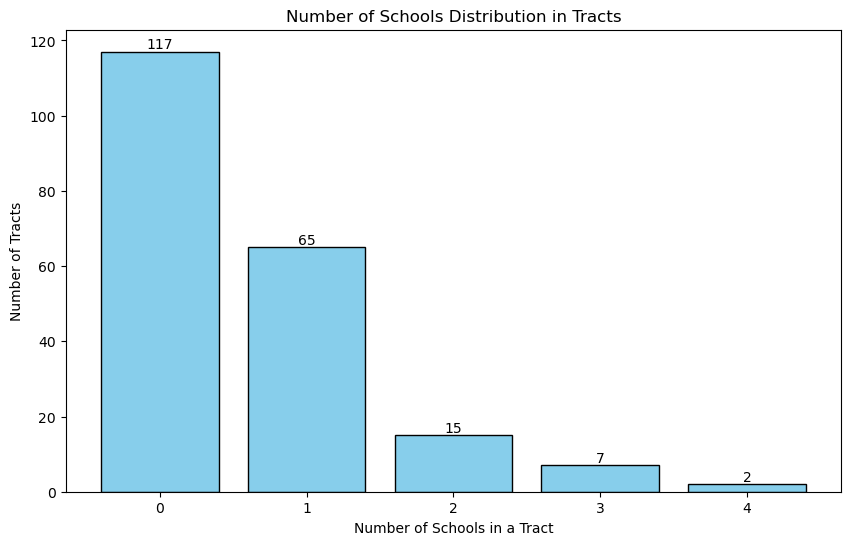

In [10]:
## The field that counts the number of points in polygons after spatial joining is called Join_Count by default
field_name = "Join_Count"

## Here I am basically using cursor to get go over just the Join_count field and storing eaching entry in a list called values
values = [row[0] for row in arcpy.da.SearchCursor(output_fc, field_name)]

# Count the occurrences of each value, dictionary cause the number of points will be treated as keys while their occurance will be treated as values
value_counts = dict(zip(*np.unique(values, return_counts=True)))

## Just getting the keys and their occurances to plot
unique_values = list(value_counts.keys())
counts = list(value_counts.values())

# Creating a ar char with matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_values, counts, color='skyblue', edgecolor='black')

## Adding Value lavels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.title(f'Number of Schools Distribution in Tracts')
plt.xlabel('Number of Schools in a Tract')
plt.ylabel('Number of Tracts')

# Show the plot
plt.show()

## Stacked Bar Chart for Number of schools and School Level

<Figure size 1200x800 with 0 Axes>

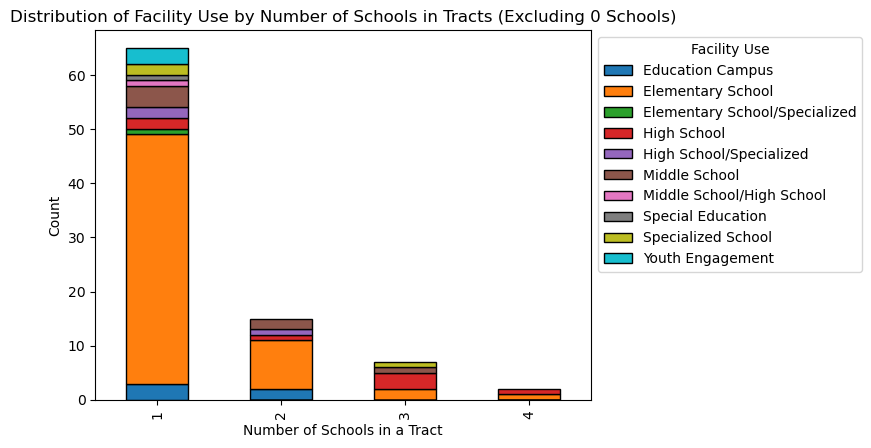

In [11]:
facility_use_field = "FACUSE"
number_of_schools_field = "Join_Count"

## Adding these two field into a Pandas Dataframe to make it easier to plot
fields = [number_of_schools_field, facility_use_field]
df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(output_fc, fields))

# Filtering out rows where the number of schools is 0
df = df[df[number_of_schools_field] > 0]

# Create a grouped bar chart
plt.figure(figsize=(12, 8))

# Group by the "Join_Count" field and "Facility_Use" field
grouped_data = df.groupby([number_of_schools_field, facility_use_field]).size().unstack(fill_value=0)

# Plot each group as a stacked bar
grouped_data.plot(kind='bar', stacked=True, edgecolor='black')

# Add labels and legend
plt.title('Distribution of Facility Use by Number of Schools in Tracts (Excluding 0 Schools)')
plt.xlabel('Number of Schools in a Tract')
plt.ylabel('Count')
plt.legend(title='Facility Use', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

## Student Population in each tract

In [22]:
fields = ["GEOID", "SUM_TOTAL_"]  # Adjust the field names as needed
student_pop = []
with arcpy.da.SearchCursor(census_tracts, fields) as cursor:
    for row in cursor:
        if row[1]!=0:
            student_pop.append(row[1])
        print(f"Tract ID: {row[0]}, Total Students: {row[1]}")

Tract ID: 11001002002, Total Students: 244.0
Tract ID: 11001002101, Total Students: 423.0
Tract ID: 11001002102, Total Students: 0.0
Tract ID: 11001002201, Total Students: 0.0
Tract ID: 11001002202, Total Students: 482.0
Tract ID: 11001000101, Total Students: 0.0
Tract ID: 11001000102, Total Students: 0.0
Tract ID: 11001000201, Total Students: 0.0
Tract ID: 11001000202, Total Students: 741.0
Tract ID: 11001000300, Total Students: 517.0
Tract ID: 11001000400, Total Students: 0.0
Tract ID: 11001000501, Total Students: 355.0
Tract ID: 11001000502, Total Students: 0.0
Tract ID: 11001000600, Total Students: 714.0
Tract ID: 11001000702, Total Students: 347.0
Tract ID: 11001000703, Total Students: 0.0
Tract ID: 11001000704, Total Students: 0.0
Tract ID: 11001000802, Total Students: 0.0
Tract ID: 11001000803, Total Students: 0.0
Tract ID: 11001000804, Total Students: 290.0
Tract ID: 11001000902, Total Students: 386.0
Tract ID: 11001000903, Total Students: 0.0
Tract ID: 11001000904, Total Stude

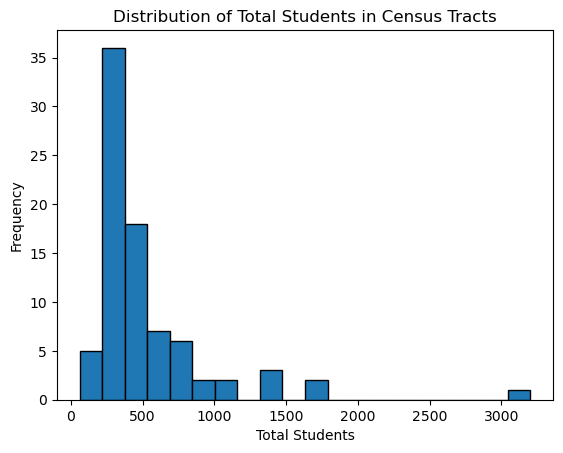

In [23]:
## Just plotting the distriution of student population in each census tract
plt.hist(student_pop, bins=20, edgecolor='black')  
plt.title('Distribution of Total Students in Census Tracts')
plt.xlabel('Total Students')
plt.ylabel('Frequency')
plt.show()

## Creating Non-Adult Population field

In [27]:
## Creating non-adult population field

new_field_name = "NAdultPop" ## Field name can only be 10 char long
arcpy.AddField_management(census_tracts, new_field_name, "LONG")

# Calculate non-adult population
expression = "!P0010001! - !P0030001!" ## Subtraction total pop from 18+ pop
arcpy.CalculateField_management(census_tracts, new_field_name, expression, "PYTHON")

print(f"Field '{new_field_name}' added and calculated successfully.")

Field 'NAdultPop' added and calculated successfully.


### Distriution of non adult population

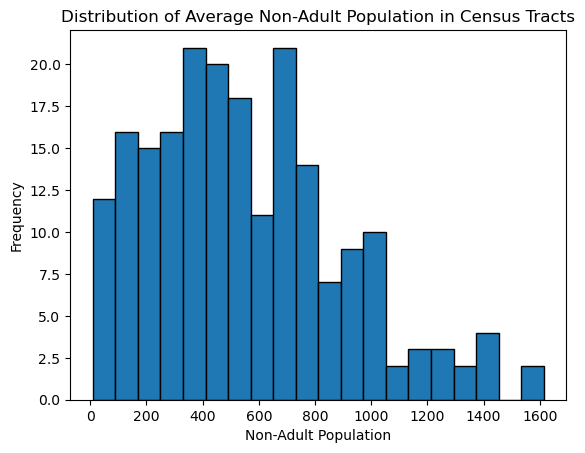

In [28]:
non_adult_population = []

with arcpy.da.SearchCursor(census_tracts, ["NAdultPop"]) as cursor:
    for row in cursor:
        non_adult_population.append(row[0])

# Create a histogram
plt.hist(non_adult_population, bins=20, edgecolor='black')  
plt.title('Distribution of Average Non-Adult Population in Census Tracts')
plt.xlabel('Non-Adult Population')
plt.ylabel('Frequency')
plt.show()

In [29]:
sum_p0010001 = sum([row[0] for row in arcpy.da.SearchCursor(census_tracts, ["NAdultPop"])])
print(f"total non adult population: {sum_p0010001}")

total non adult population: 114384


### Calculating the ratio of students to non adults population

In [30]:
## Have done a try block here as this would give me an error if I run this again as the student% field is already created

try:
    non_adult_field = "NAdultPop"

    # Calculate average number of students for the total population of non-adults
    arcpy.management.CalculateField(
        in_table=census_tracts,
        field="student%",
        expression="!SUM_TOTAL_! / !{}!".format(non_adult_field),
        expression_type="PYTHON"
    )
except:
    print("Field Already Exists")

Field Already Exists


### CDF Graph for number of students

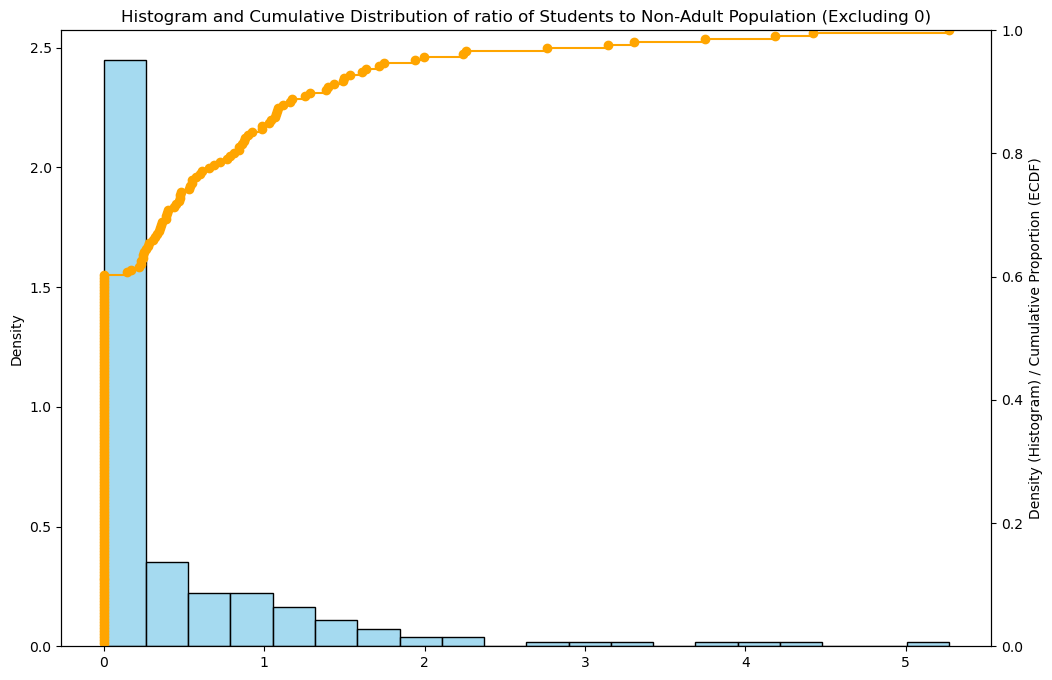

In [33]:
student_field = "student_"

# Read data into a list, excluding values where student_ is 0
avg_students_non_adults = []

## Just iteration of each row in searchcursor and storing it in a list
with arcpy.da.SearchCursor(census_tracts, [student_field]) as cursor:
    for row in cursor:
        if row[0] != 0:
            avg_students_non_adults.append(float(row[0]))  # Converting to float, cause it's in string format for some reason

# Create a histogram
plt.figure(figsize=(12, 8))
            
hist = sns.histplot(avg_students_non_adults, bins=20, kde=False, color='skyblue', edgecolor='black', stat='density')

# Plot cumulative distribution
cumulative = hist.twinx()
sns.ecdfplot(avg_students_non_adults, color='orange', linestyle='-', marker='o', ax=cumulative)

plt.title('Histogram and Cumulative Distribution of ratio of Students to Non-Adult Population (Excluding 0)')
plt.xlabel('Average Students for Non-Adults')
plt.ylabel('Density (Histogram) / Cumulative Proportion (ECDF)')
plt.show()

## Whisker Plot for Non Adult population and numer of schools

In [34]:
non_adult_field = "NAdultPop"


# Join the non-adult population from census tracts to the statistics table based on GEOID
arcpy.management.JoinField(
    in_data=output_fc,
    in_field="GEOID",
    join_table=census_tracts,
    join_field="GEOID",
    fields=[non_adult_field]
)

# Reading data into lists
num_schools = [row[0] for row in arcpy.da.SearchCursor(output_fc, "Join_Count")]
non_adult_population = [row[0] for row in arcpy.da.SearchCursor(output_fc, non_adult_field)]


## Adding List to pandas dataframe for easier plotting
import pandas as pd
df = pd.DataFrame({'Number of Schools': num_schools, 'Non-Adult Population': non_adult_population})


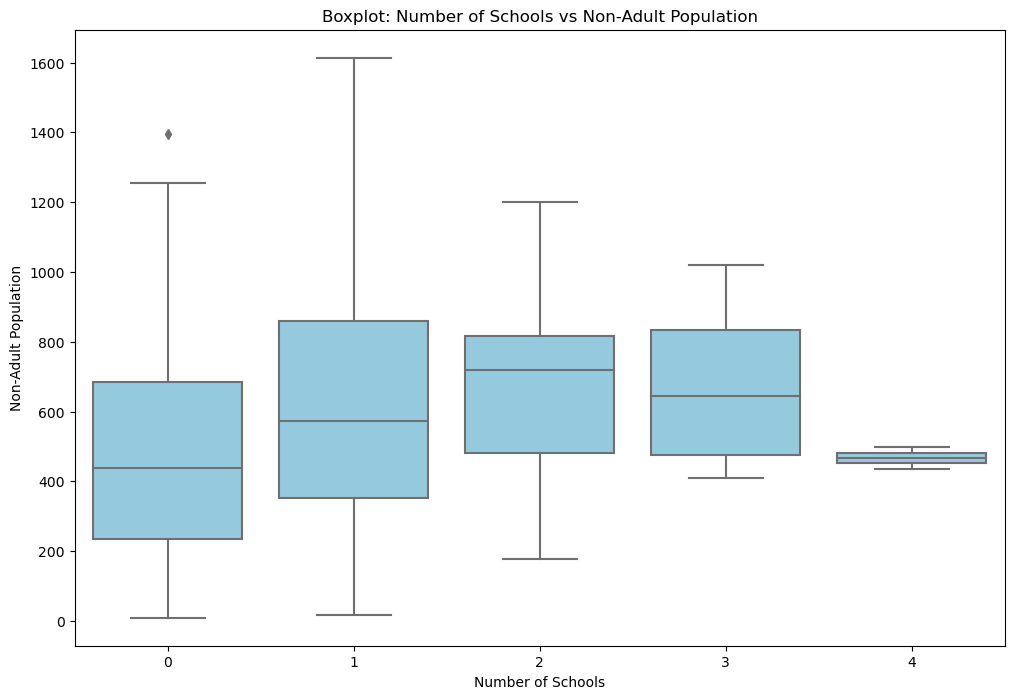

In [35]:
plt.figure(figsize=(12, 8))  

# Create a whisker plot using Seaborn
sns.boxplot(data=df, x='Number of Schools', y='Non-Adult Population', color='skyblue')

plt.title('Boxplot: Number of Schools vs Non-Adult Population')
plt.xlabel('Number of Schools')
plt.ylabel('Non-Adult Population')

plt.show()

## Whisker Plot for Number of Students and Number of Schools

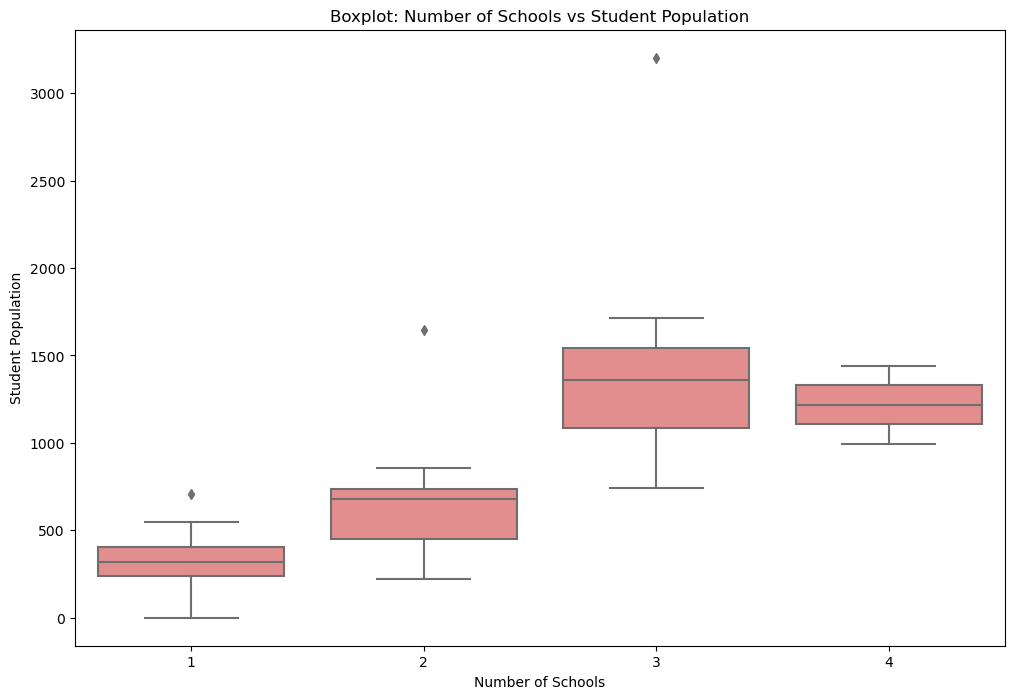

In [36]:
student_population_field = "SUM_TOTAL_"


## Doing the same as before just for a the SUM_TOTAL_ field now
arcpy.management.JoinField(
    in_data=output_fc,
    in_field="GEOID",
    join_table=census_tracts,
    join_field="GEOID",
    fields=[student_population_field]
)

student_population = [float(row[0]) for row in arcpy.da.SearchCursor(output_fc, student_population_field)] 

import pandas as pd
df = pd.DataFrame({'Number of Schools': num_schools, 'Student Population': student_population})
df = df[df['Number of Schools'] > 0]  ## Just taking the entries where there's atleast one school


plt.figure(figsize=(12, 8))  

sns.boxplot(data=df, x='Number of Schools', y='Student Population', color='lightcoral')

plt.title('Boxplot: Number of Schools vs Student Population')
plt.xlabel('Number of Schools')
plt.ylabel('Student Population')

# Show the plot
plt.show()

## Joinging Median Household income file to the previous join - "output_fc"

In [39]:
spatial_join_output_fc = "median_income_join.shp"

arcpy.analysis.SpatialJoin(
    target_features=output_fc,
    join_features=Median_household_income,
    out_feature_class=spatial_join_output_fc,
    join_type="KEEP_COMMON",
    match_option="INTERSECT"
)

<Result 's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data\\median_income_join.shp'>

## Scatterplot between number of students in each census tract and the median household income 

In [40]:
features = []

# Using search cursor to iterate through the features in the spatial join output feature class and appending it to a list
fields = ['B19049_001', 'SUM_TOTAL_']
with arcpy.da.SearchCursor(spatial_join_output_fc, fields) as cursor:
    for row in cursor:
        feature = {
            'Median_Household_Income': row[0],
            'frequency': float(row[1]),
        }
        features.append(feature)

# Creating a pandas DataFrame from the list of features
df = pd.DataFrame(features)
df = df[df['Median_Household_Income'] > 0]
df = df[df['frequency'] > 0]



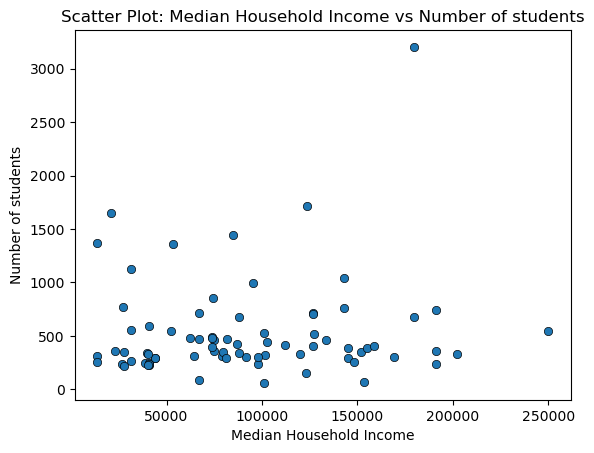

In [41]:


# Create a scatter plot using Seaborn
sns.scatterplot(data=df, x='Median_Household_Income', y='frequency', edgecolor='black')

plt.title('Scatter Plot: Median Household Income vs Number of students')
plt.xlabel('Median Household Income')
plt.ylabel('Number of students')

plt.show()

## Calculating the bottom 10 and top 10 percentile for median household income

In [42]:
median_income_field = "B19049_001"

# Read the income values into a NumPy array
income_values = arcpy.da.FeatureClassToNumPyArray(Median_household_income, [median_income_field])

# Calculate percentiles using NumPy
percentiles = np.percentile(income_values[median_income_field], [10, 90])

bottom_10_percentile = percentiles[0]
top_10_percentile = percentiles[1]

print(f"Bottom 10% Income Threshold: {bottom_10_percentile}")
print(f"Top 10% Income Threshold: {top_10_percentile}")

Bottom 10% Income Threshold: 31343.8
Top 10% Income Threshold: 147848.2


## Making bar chart for Number of schools across different income Groups

#### Using SQL queries to calculate groups

In [43]:
# Create a layer for the spatial join result
arcpy.MakeFeatureLayer_management(spatial_join_output_fc, "spatial_join_layer")

# Calculate percentiles using NumPy
percentiles = np.percentile(arcpy.da.FeatureClassToNumPyArray(spatial_join_output_fc, [median_income_field])[median_income_field], [10, 50, 90])

bottom_10_percentile = percentiles[0]
percentile_10_50 = percentiles[1]
percentile_50_90 = percentiles[2]


## Using SQL Queries here to get the bottom 10, 10-50, 50-90, and 90+ group
bottom_10_percentile_clause = f"B19049_001 <= {bottom_10_percentile}"
percentile_10_50_clause = f"({bottom_10_percentile} < B19049_001) AND (B19049_001 <= {percentile_10_50})"
percentile_50_90_clause = f"({percentile_10_50} < B19049_001) AND (B19049_001 <= {percentile_50_90})"
top_90_percentile_clause = f"B19049_001 > {percentile_50_90}"


print(f"Bottom 10% Clause: {bottom_10_percentile_clause}")
print(f"10-50% Clause: {percentile_10_50_clause}")
print(f"50-90% Clause: {percentile_50_90_clause}")
print(f"Top 90% Clause: {top_90_percentile_clause}")

## Selecting Layers
arcpy.SelectLayerByAttribute_management("spatial_join_layer", "NEW_SELECTION", bottom_10_percentile_clause)
arcpy.SelectLayerByAttribute_management("spatial_join_layer", "ADD_TO_SELECTION", percentile_10_50_clause)
arcpy.SelectLayerByAttribute_management("spatial_join_layer", "ADD_TO_SELECTION", percentile_50_90_clause)
arcpy.SelectLayerByAttribute_management("spatial_join_layer", "ADD_TO_SELECTION", top_90_percentile_clause)

# Create a new feature class containing only the selected features
selected_features_fc = "selected_feature.shp"
arcpy.CopyFeatures_management("spatial_join_layer", selected_features_fc)



Bottom 10% Clause: B19049_001 <= 27441.5
10-50% Clause: (27441.5 < B19049_001) AND (B19049_001 <= 84045.5)
50-90% Clause: (84045.5 < B19049_001) AND (B19049_001 <= 162375.0)
Top 90% Clause: B19049_001 > 162375.0


<Result 's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data\\selected_feature.shp'>

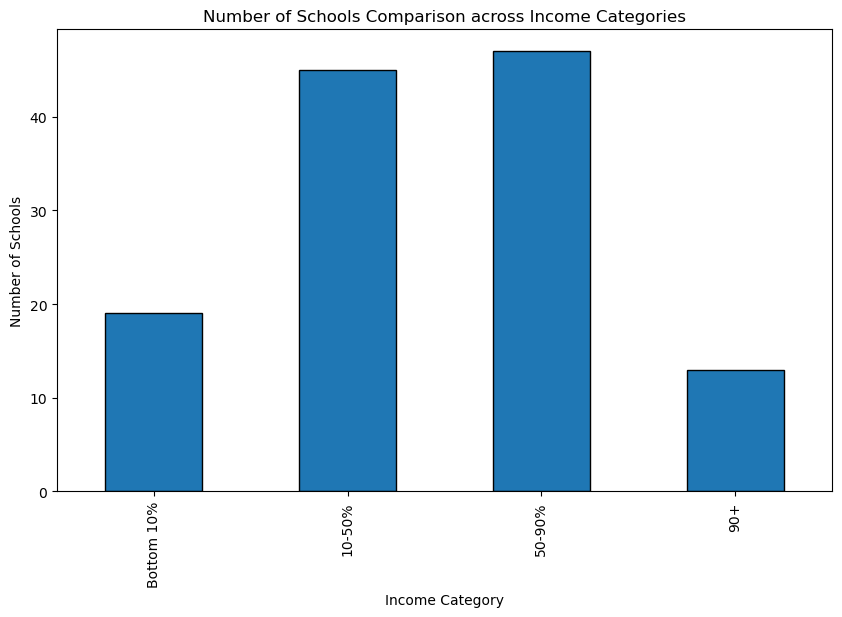

In [44]:
# Read the selected features class into a Pandas DataFrame
selected_df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(selected_features_fc, [median_income_field, 'Join_Count']))

# Classify each row into income categories
selected_df['Income_Category'] = pd.cut(
    selected_df[median_income_field],
    bins=[-np.inf, bottom_10_percentile, percentile_10_50, percentile_50_90, np.inf],
    labels=['Bottom 10%', '10-50%', '50-90%', '90+']
)

# Plot a grouped bar chart
plt.figure(figsize=(10, 6))
selected_df.groupby('Income_Category')['Join_Count'].sum().plot(kind='bar', edgecolor='black')
plt.title('Number of Schools Comparison across Income Categories')
plt.xlabel('Income Category')
plt.ylabel('Number of Schools')
plt.show()

## Bar chart for non adult population across income categories

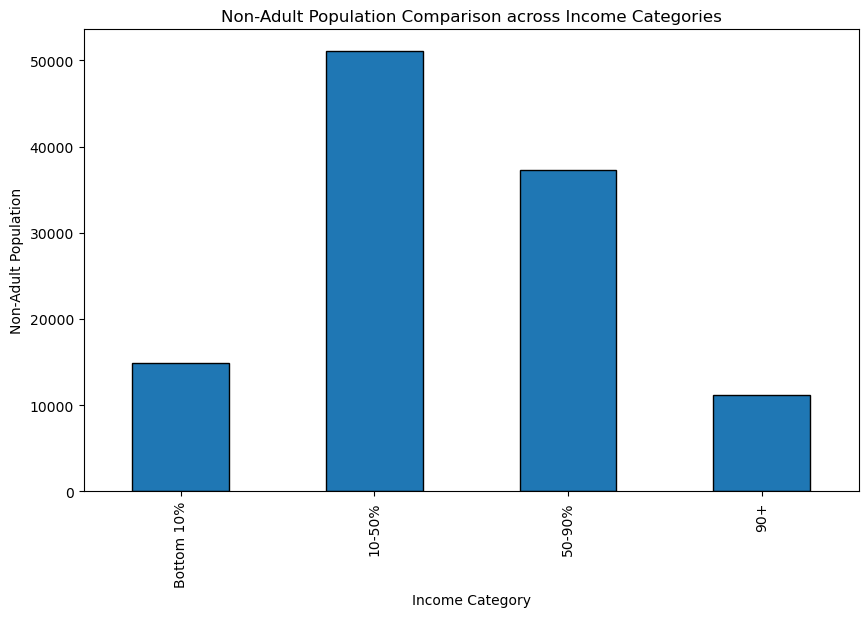

In [45]:

## Same code as above just changed the field names to NAdultPop to get the non adult pop chart

selected_df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(selected_features_fc, [median_income_field, 'Join_Count', 'NAdultPop']))

selected_df['Income_Category'] = pd.cut(
    selected_df[median_income_field],
    bins=[-np.inf, bottom_10_percentile, percentile_10_50, percentile_50_90, np.inf],
    labels=['Bottom 10%', '10-50%', '50-90%', '90+']
)

plt.figure(figsize=(10, 6))
selected_df.groupby('Income_Category')['NAdultPop'].sum().plot(kind='bar', edgecolor='black')
plt.title('Non-Adult Population Comparison across Income Categories')
plt.xlabel('Income Category')
plt.ylabel('Non-Adult Population')
plt.show()

## Calculating non-white population in each census tract

In [46]:
minority_field = "P0020005" ## This the white only population field
total_population_field = "P0010001"
minority_percentage_field = "Minority_P"

fields = arcpy.ListFields(census_tracts)
field_dict = {field.name: field.type for field in fields}
if minority_field not in field_dict or total_population_field not in field_dict:
    print("Fields do not exist in the dataset.") 
else:
    minority_field_type = field_dict[minority_field]
    total_population_field_type = field_dict[total_population_field]

    # Checking for data type compatibility
    if minority_field_type == total_population_field_type:
        common_data_type = minority_field_type
    elif minority_field_type in ["Integer", "Double"] and total_population_field_type in ["Integer", "Double"]:
        common_data_type = "Double"
    else:
        print("Field data types are not compatible for the calculation.")
        common_data_type = None

    if common_data_type:
        # Calculating the new field
        expression = f"(1- (!{minority_field}! / !{total_population_field}!)) * 100"
        print(f"Expression: {expression}")

        arcpy.management.CalculateField(census_tracts, minority_percentage_field, expression, "PYTHON")
        print("Calculation completed successfully.")

Expression: (1- (!P0020005! / !P0010001!)) * 100
Calculation completed successfully.


In [47]:
minority_percentage_field = "Minority_P"


# Joining the minority population from census tracts to the statistics table based on GEOID
arcpy.management.JoinField(
    in_data=output_fc,
    in_field="GEOID",
    join_table=census_tracts,
    join_field="GEOID",
    fields=[minority_percentage_field]
)

<Result 's:\\CCAS Students\\DATS_6450.81_Topics_in_Data_Science_202303\\Verma,Akshay-AVerma\\Project_data\\Data\\schools_in_tracts.shp'>

## School distriution by minority pop %

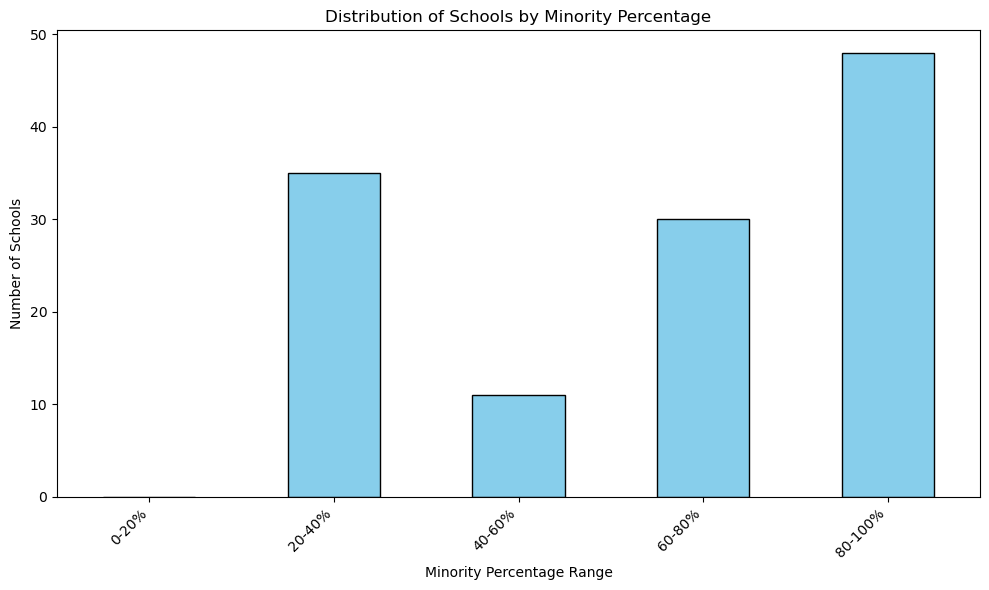

In [48]:
df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(output_fc, [minority_percentage_field, 'Join_Count']))

bins = [0, 20, 40, 60, 80, 100]

# Creating labels for the bins
bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

# Add a new column with bin labels
df['Minority_Bin'] = pd.cut(df[minority_percentage_field], bins=bins, labels=bin_labels, include_lowest=True)

# Group by Minority_Bin and calculate the sum of Join_Count for each bin
grouped_data = df.groupby('Minority_Bin')['Join_Count'].sum()

# Plot the bar chart
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Schools by Minority Percentage')
plt.xlabel('Minority Percentage Range')
plt.ylabel('Number of Schools')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Elementary School by Minority pop %

<Figure size 1200x800 with 0 Axes>

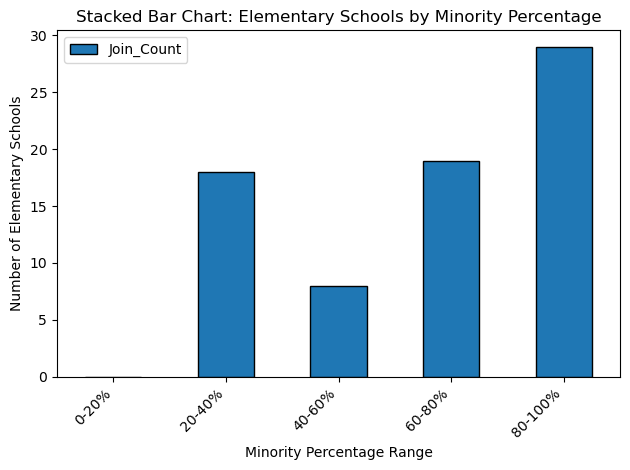

In [49]:
minority_percentage_field = "Minority_P"
join_count_field = "Join_Count"
facility_use_field = "FACUSE"

# Convert feature class to Pandas DataFrame
df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(output_fc, [minority_percentage_field, join_count_field, facility_use_field]))
df = df[df[facility_use_field] == "Elementary School"]

# Create bins for minority percentage
bins = [0, 20, 40, 60, 80, 100]

# Create labels for the bins
bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

# Add a new column with bin labels
df['Minority_Bin'] = pd.cut(df[minority_percentage_field], bins=bins, labels=bin_labels, include_lowest=True)

# Create a pivot table to get counts for each combination of Minority_Bin and FACUSE
pivot_table = pd.pivot_table(df, values=join_count_field, index=['Minority_Bin'], aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, edgecolor='black')
plt.title('Stacked Bar Chart: Elementary Schools by Minority Percentage')
plt.xlabel('Minority Percentage Range')
plt.ylabel('Number of Elementary Schools')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

## Scatter plot between Minority % and Non-Adult Pop

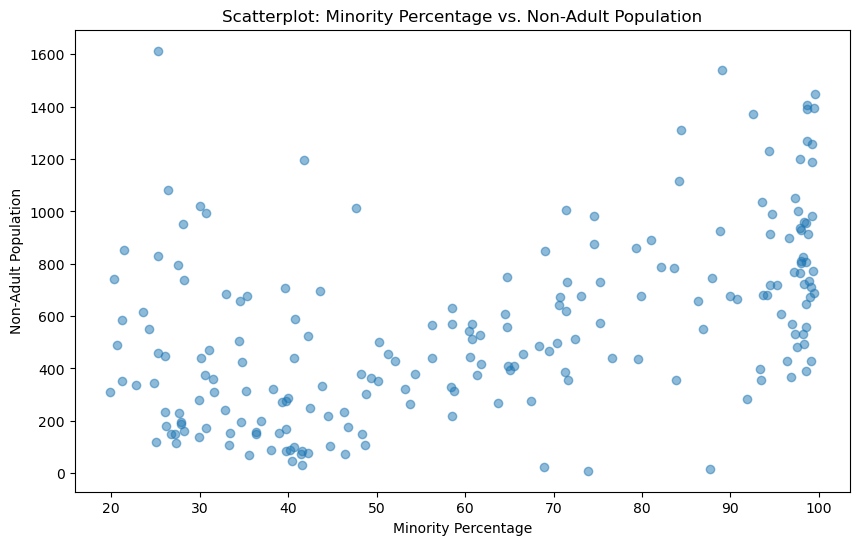

In [50]:
minority_percentage_field = "Minority_P"
non_adult_population_field = "NAdultPop"

# Convert feature class to Pandas DataFrame
df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(output_fc, [minority_percentage_field, non_adult_population_field]))

# Plot the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df[minority_percentage_field], df[non_adult_population_field], alpha=0.5)
plt.title('Scatterplot: Minority Percentage vs. Non-Adult Population')
plt.xlabel('Minority Percentage')
plt.ylabel('Non-Adult Population')

# Show the plot
plt.show()

## Choropleth Maps
### ONLY USING GEOPANDAS FOR THIS

In [66]:
census_tract_gdf = gpd.read_file('S:\CCAS Students\DATS_6450.81_Topics_in_Data_Science_202303\Verma,Akshay-AVerma\Project_data\Data\Census_Tracts_in_2020.shp')
dc_schools_gdf = gpd.read_file('S:\CCAS Students\DATS_6450.81_Topics_in_Data_Science_202303\Verma,Akshay-AVerma\Project_data\Data\DC_Public_Schools.shp')
Median_household_income_gdf = gpd.read_file('S:\CCAS Students\DATS_6450.81_Topics_in_Data_Science_202303\Verma,Akshay-AVerma\Project_data\Data\median_income_join.shp')

# Perform a spatial join
merged_gdf = gpd.sjoin(dc_schools_gdf, census_tract_gdf, how="left", op="within")



c:\ProgramData\Anaconda3\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [62]:
census_tract_gdf.columns

Index(['OBJECTID', 'TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003',
       'P0010004', 'P0010005', 'P0010006', 'P0010007',
       ...
       'P0050010', 'SHAPEAREA', 'SHAPELEN', 'GEOID_1', 'FREQUENCY',
       'SUM_TOTAL_', 'NAdultPop', 'student_', 'Minority_P', 'geometry'],
      dtype='object', length=322)

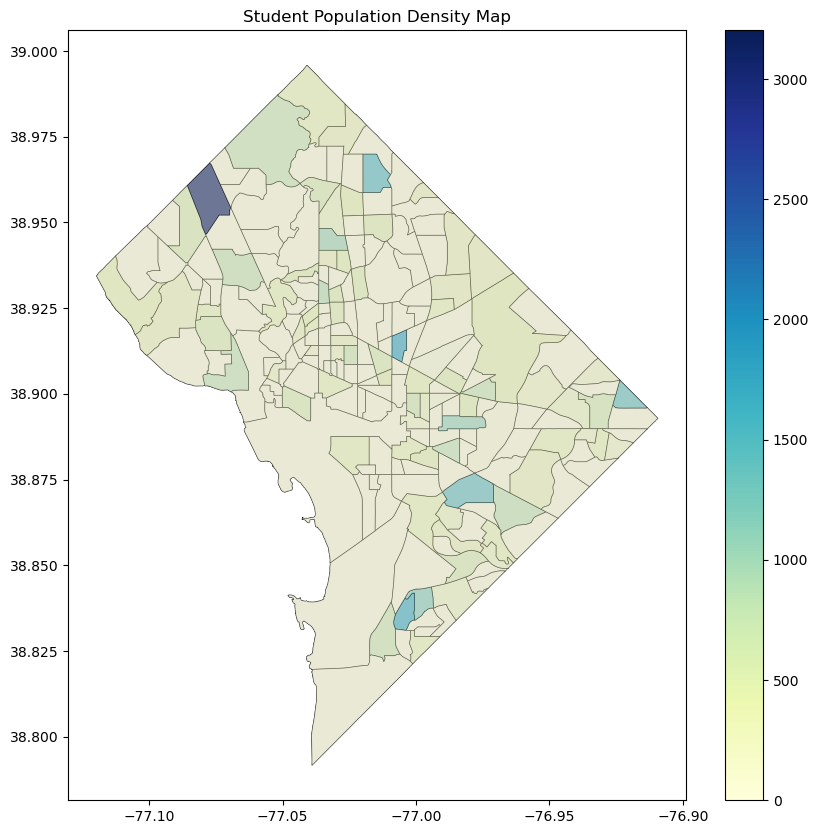

In [60]:
# Plot the choropleth map with census tract boundaries
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Student Population Density Map")

# Plot census tract boundaries
census_tract_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)

# Plot DC schools with choropleth values
census_tract_gdf.plot(ax=ax, column="SUM_TOTAL_", cmap="YlGnBu", legend=True, markersize=50, alpha=0.5)

plt.show()

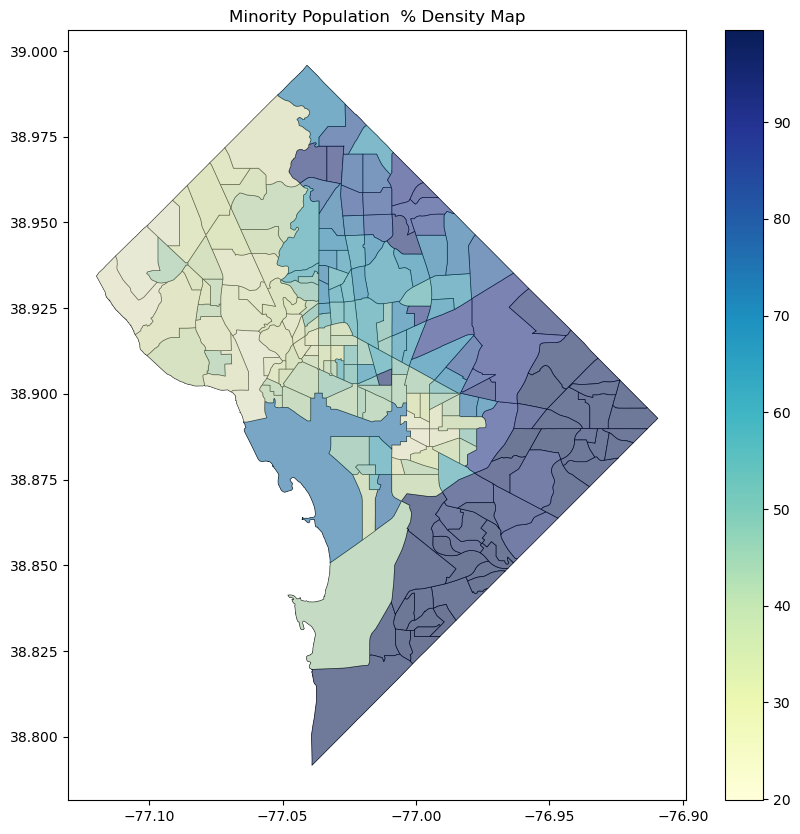

In [68]:
# Plot the choropleth map with census tract boundaries
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Minority Population  % Density Map")

# Plot census tract boundaries
census_tract_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)

# Plot DC schools with choropleth values
census_tract_gdf.plot(ax=ax, column="Minority_P", cmap="YlGnBu", legend=True, markersize=50, alpha=0.5)

plt.show()

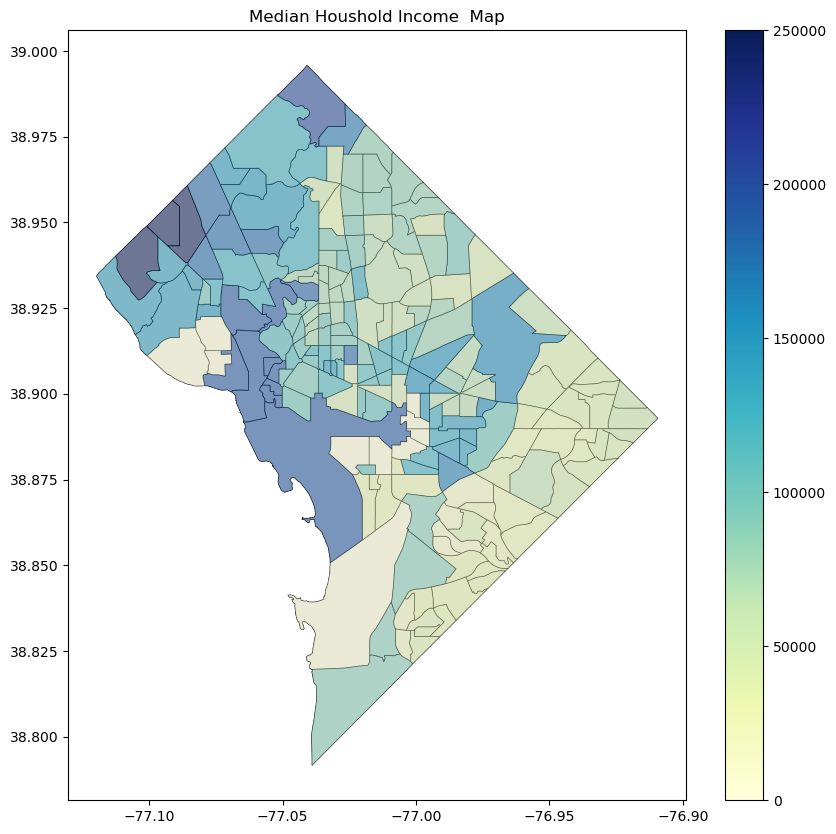

In [69]:
# Plot the choropleth map with census tract boundaries
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Median Houshold Income  Map")

# Plot census tract boundaries
Median_household_income_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)

# Plot DC schools with choropleth values
Median_household_income_gdf.plot(ax=ax, column="B19049_001", cmap="YlGnBu", legend=True, markersize=50, alpha=0.5)

plt.show()